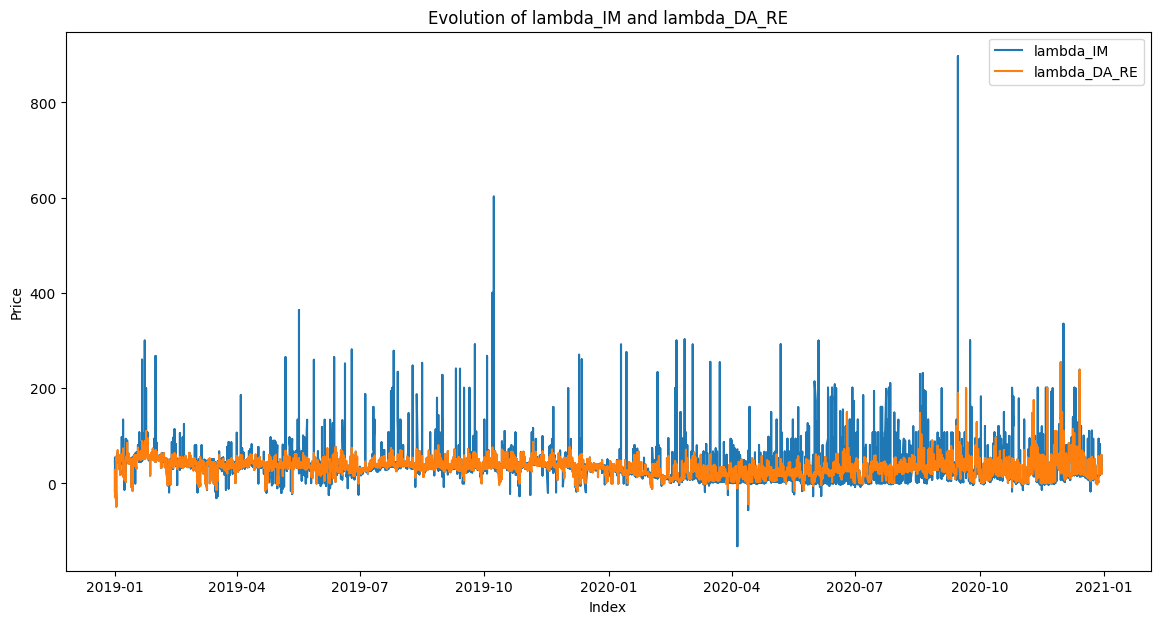

                     avg_lambda_IM  avg_lambda_DA_RE  total_count  \
2019-01-31 00:00:00      54.189171         51.655027          744   
2019-02-28 00:00:00      43.037723         43.932946          672   
2019-03-31 00:00:00      35.753838         35.643957          743   
2019-04-30 00:00:00      39.075904         39.892097          720   
2019-05-31 00:00:00      41.390929         38.151398          744   
2019-06-30 00:00:00      32.081211         33.622236          720   
2019-07-31 00:00:00      40.218886         39.000175          744   
2019-08-31 00:00:00      41.864055         39.493172          744   
2019-09-30 00:00:00      37.765097         37.321347          720   
2019-10-31 00:00:00      43.486610         41.499879          745   
2019-11-30 00:00:00      42.279649         42.696444          720   
2019-12-31 00:00:00      35.911076         35.347110          744   
2020-01-31 00:00:00      26.138056         27.385242          744   
2020-02-29 00:00:00      23.805720

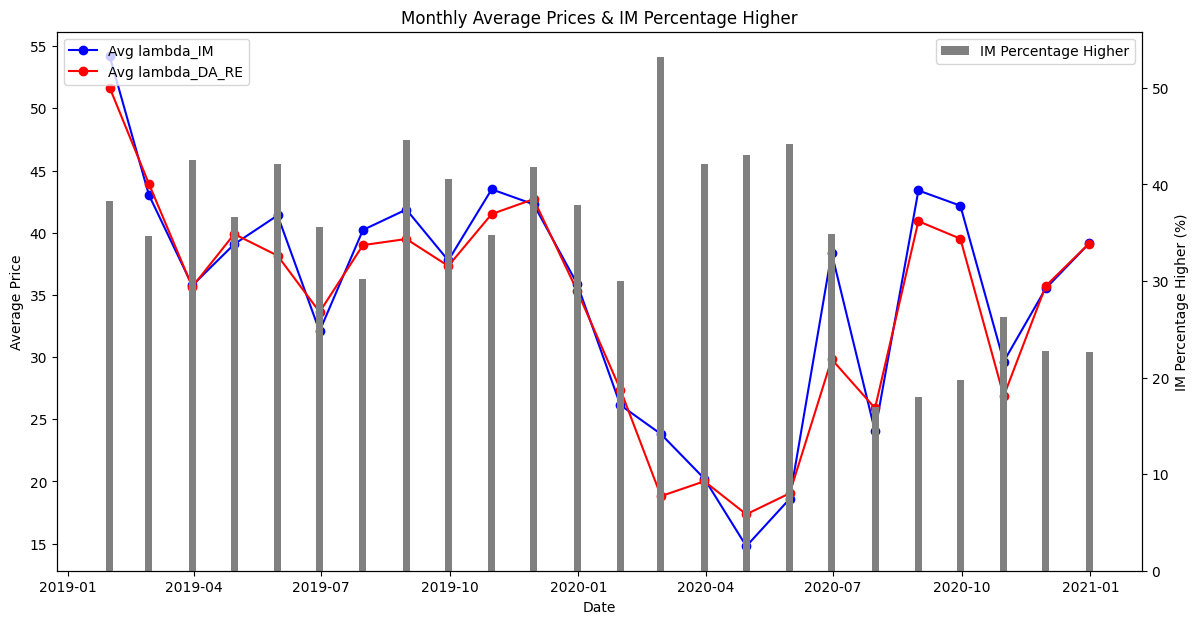

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('../data/processed/data.csv')

data['date'] = pd.to_datetime(data['date'])

# Plot the evolution of prices
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['lambda_IM'], label='lambda_IM')
plt.plot(data['date'], data['lambda_DA_RE'], label='lambda_DA_RE')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Evolution of lambda_IM and lambda_DA_RE')
plt.legend()
plt.show()

# Extract relevant columns
data['higher_balancing'] = data['lambda_IM'] > data['lambda_DA_RE']

# Function to compute summary statistics
def compute_summary(df, freq):
    grouped = df.resample(freq, on='date').agg(
        avg_lambda_IM=('lambda_IM', 'mean'),
        avg_lambda_DA_RE=('lambda_DA_RE', 'mean'),
        total_count=('lambda_IM', 'count'),
        IM_higher_count=('higher_balancing', 'sum')
    )
    grouped['IM_percentage_higher'] = (grouped['IM_higher_count'] / grouped['total_count']) * 100
    return grouped

# Compute monthly and yearly summaries
monthly_summary = compute_summary(data, 'ME')
yearly_summary = compute_summary(data, 'YE')

# Compute overall summary
overall_summary = pd.DataFrame({
    "avg_lambda_IM": [data["lambda_IM"].mean()],
    "avg_lambda_DA_RE": [data["lambda_DA_RE"].mean()],
    "total_count": [len(data)],
    "IM_higher_count": [(data["lambda_IM"] > data["lambda_DA_RE"]).sum()],
})
overall_summary["IM_percentage_higher"] = (overall_summary["IM_higher_count"] / overall_summary["total_count"]) * 100

# Combine results
monthly_summary["type"] = "Monthly"
yearly_summary["type"] = "Yearly"
overall_summary["type"] = "Overall"
overall_summary.index = ["Overall"]

# Concatenate into a single DataFrame
summary_df = pd.concat([monthly_summary, yearly_summary, overall_summary])

print(summary_df)

# Filter only the monthly summary
monthly_summary_filtered = summary_df[summary_df["type"] == "Monthly"]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Line plot for average prices
ax1.plot(monthly_summary_filtered.index, monthly_summary_filtered["avg_lambda_IM"], label="Avg lambda_IM", color="blue", marker='o')
ax1.plot(monthly_summary_filtered.index, monthly_summary_filtered["avg_lambda_DA_RE"], label="Avg lambda_DA_RE", color="red", marker='o')
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Price")
ax1.tick_params(axis="y")
ax1.legend(loc="upper left")

# Create secondary y-axis for percentage higher
ax2 = ax1.twinx()
ax2.bar(monthly_summary_filtered.index, monthly_summary_filtered["IM_percentage_higher"], width=5, color="gray", label="IM Percentage Higher")
ax2.set_ylabel("IM Percentage Higher (%)")
ax2.tick_params(axis="y")

# Add a legend for the bar chart
ax2.legend(loc="upper right")

# Title
plt.title("Monthly Average Prices & IM Percentage Higher")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()



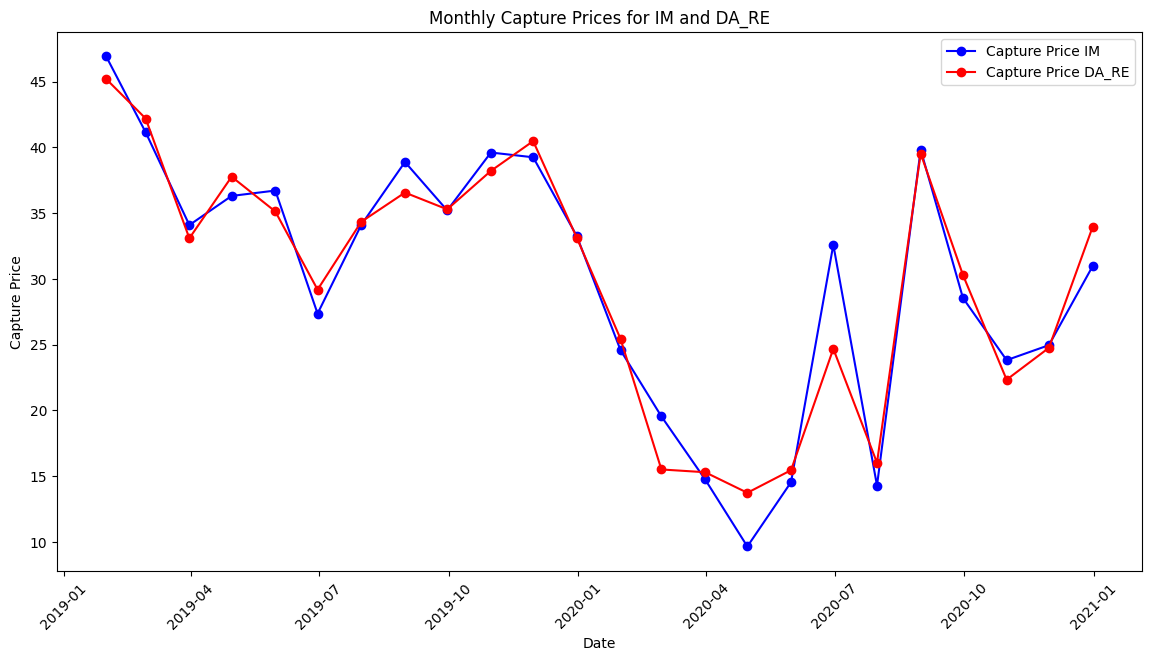

In [27]:
# Function to compute capture prices (weighted averages)
def compute_capture_price(df, freq):
    grouped = df.resample(freq, on='date').agg(
        total_energy=('energy_RE', 'sum'),
        weighted_lambda_IM=('lambda_IM', lambda x: (x * df.loc[x.index, 'energy_RE']).sum()),
        weighted_lambda_DA_RE=('lambda_DA_RE', lambda x: (x * df.loc[x.index, 'energy_RE']).sum()),
    )
    grouped['capture_price_IM'] = grouped['weighted_lambda_IM'] / grouped['total_energy']
    grouped['capture_price_DA_RE'] = grouped['weighted_lambda_DA_RE'] / grouped['total_energy']
    return grouped[['capture_price_IM', 'capture_price_DA_RE']]

# Compute monthly and yearly capture prices
monthly_capture_prices = compute_capture_price(data, 'ME')
yearly_capture_prices = compute_capture_price(data, 'YE')

plt.figure(figsize=(14, 7))
plt.plot(monthly_capture_prices.index, monthly_capture_prices["capture_price_IM"], label="Capture Price IM", marker='o', color='blue')
plt.plot(monthly_capture_prices.index, monthly_capture_prices["capture_price_DA_RE"], label="Capture Price DA_RE", marker='o', color='red')
plt.xlabel("Date")
plt.ylabel("Capture Price")
plt.title("Monthly Capture Prices for IM and DA_RE")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [28]:
yearly_capture_prices

,capture_price_IM,capture_price_DA_RE
date,,
2019-12-31,37.099960,36.875219
2020-12-31,22.461969,22.228986
